In [1]:
# import libraries for data analysis
#%matplotlib notebook
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
matplotlib.rcParams['figure.figsize'] = (14, 6)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
matplotlib.rcParams['font.weight'] = 'normal'

In [2]:
# import the data
trial = "10-Push"
fileName = "Gravel_10Push_1"
surface = "Gravel"
rlData = pd.read_csv("./src/" + fileName + "_RL_Redo.CSV")
swData = pd.read_csv("./src/" + fileName + "_SW_Redo - Foramt 2.CSV")
sensor_distance = 0.203
wheel_radius = 0.308

In [3]:
# define a kalman filter function
def kalman(x, p=1, q=0.0001, r=0.01):
    # initialize the output
    y = np.zeros(len(x))
    
    # temporary variables
    x0 = 0
    
    # loop over the dataset
    for i in range(0, len(x)):
        # calculate the current gain
        k = (p + q) / (p + q + r)
        
        # update the prediction
        p = r * (p + q) / (p + q + r)
        
        # update the result
        xi = x0 + (x[i] - x0) * k
        x0 = xi
        y[i] = xi
        
    # return
    return y

In [4]:
# Get our relevant data out of the two datasets
rlT = rlData['Timestamp']
rlAx = kalman(rlData['A_x'], p=1, q=0.0001, r=0.01)
rlBx = kalman(rlData['B_x'], p=1, q=0.0001, r=0.01)
swV = swData['Speed [m/s]'].values
swT = np.linspace(0, swV.size / 240, swV.size)

In [5]:
# Calculate our Redliner data
rlDa = np.subtract(rlBx, rlAx) - 0.0546;
rlDa = np.piecewise(rlDa, [rlDa <= 0, rlDa > 0], [lambda rlDa: 0, lambda rlDa: rlDa])
rlV = np.sqrt(rlDa / sensor_distance) * wheel_radius

# smooth things a bit
rlV = kalman(rlV, p=1, q=0.0001, r=0.01)
swV = kalman(swV, p=1, q=0.0001, r=0.01)

In [6]:
# Prep for plotting
# These are the "Tableau 20" colors as RGB. 
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [7]:
# differentiate to get acceleration
rlDt = np.subtract(rlT[1:-1], rlT[0:-2])
rlDv = np.subtract(rlV[1:-1], rlV[0:-2])
rlA = np.divide(rlDv, rlDt)
rlTa = rlT[1:-1]
swDt = np.subtract(swT[1:-1], swT[0:-2])
swDv = np.subtract(swV[1:-1], swV[0:-2])
swA = np.divide(swDv, swDt)
swTa = swT[1:-1]

# smooth it out
rlA = kalman(rlA.values, p=1, q=0.00001, r=0.0001)
swA = kalman(swA, p=1, q=0.0001, r=0.01)

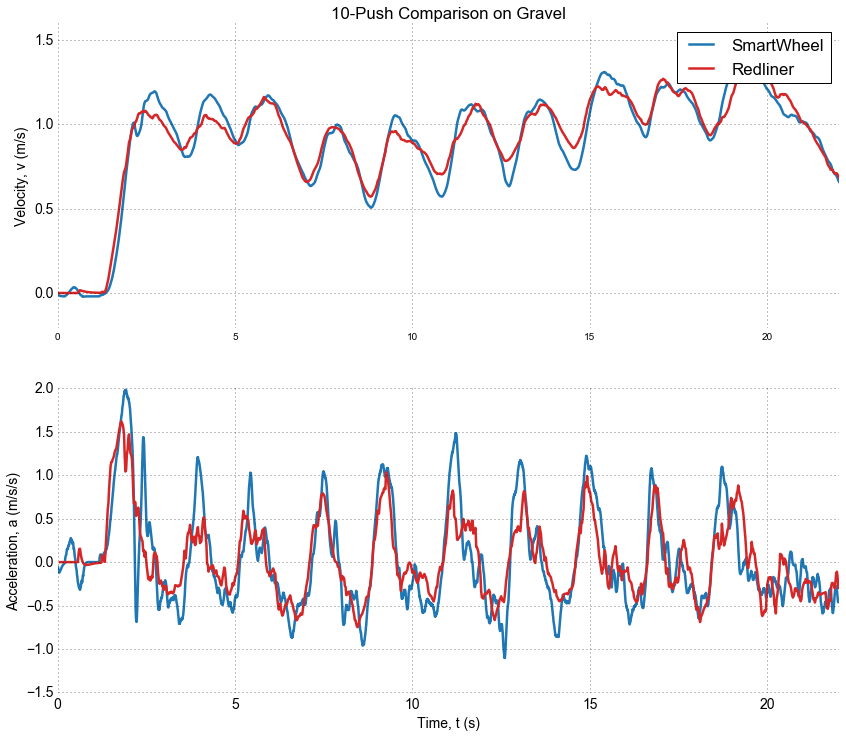

In [8]:
# offset the SmartWheel in time so the traces line up
swOffset = 3.75;

# start a new figure!
plt.figure(figsize=(14, 12))

# velocity!
ax1 = plt.subplot(211)
plt.plot(swT - swOffset, swV, label='SmartWheel', lw=2.5, color=tableau20[0])
plt.plot(rlT, rlV, label='Redliner', lw=2.5, color=tableau20[6])

plt.title(trial + ' Comparison on '+ surface)
plt.ylabel('Velocity, v (m/s)')
#plt.xlabel('Time, t (s)')
plt.setp(ax1.get_xticklabels(), fontsize=10)

ax = plt.gca()
x1,x2,y1,y2 = plt.axis()
ax.set_xlim([0, np.floor(rlT.max()-swOffset) + 0.025])
ax.set_ylim([y1-0.005, y2])
plt.grid()
plt.legend()

# remove the plot frame lines
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# Ensure that the axis ticks only show up on the bottom and left of the plot.
# Ticks on the right and top of the plot are generally unnecessary chartjunk.
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# Make sure your axis ticks are large enough to be easily read.
# You don't want your viewers squinting to read your plot.
plt.yticks()
plt.xticks()

# Remove the tick marks; they are unnecessary with the tick lines we just plotted.
plt.tick_params(axis="both", which="both", bottom="off", top="off",
                labelbottom="on", left="off", right="off", labelleft="on")

#plt.tight_layout()

# acceleration
ax2 = plt.subplot(212, sharex=ax1)
plt.plot(swTa - swOffset, swA, label='SmartWheel', lw=2.5, color=tableau20[0])
plt.plot(rlTa, rlA, label='Redliner', lw=2.5, color=tableau20[6])

plt.ylabel('Acceleration, a (m/s/s)')
plt.xlabel('Time, t (s)')

ax = plt.gca()
x1,x2,y1,y2 = plt.axis()
ax.set_xlim([0, np.floor(rlT.max()-swOffset) + 0.025])
ax.set_ylim([y1-0.005, y2])
plt.grid()

# remove the plot frame lines
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# Ensure that the axis ticks only show up on the bottom and left of the plot.
# Ticks on the right and top of the plot are generally unnecessary chartjunk.
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# Make sure your axis ticks are large enough to be easily read.
# You don't want your viewers squinting to read your plot.
plt.yticks()
plt.xticks()

# Remove the tick marks; they are unnecessary with the tick lines we just plotted.
plt.tick_params(axis="both", which="both", bottom="off", top="off",
                labelbottom="on", left="off", right="off", labelleft="on")

#plt.tight_layout()

# Show a legend
#plt.legend(loc = 'lower center', bbox_to_anchor = (0,-0.05,1,1), bbox_transform = plt.gcf().transFigure )

# save it
#plt.savefig("../figures/" + fileName + ".png")
plt.savefig("assets/test.pdf", format='pdf')

## 

In [9]:
df = pd.DataFrame({
        "t": (swT - swOffset)[::25],
        "v": swV[::25]
    })
df.to_csv('assets/gravel_10_swv.dat', sep=' ', index=False)

In [10]:
df = pd.DataFrame({
        "t": rlT,
        "v": rlV
    })
df.to_csv('assets/gravel_10_rlv.dat', sep=' ', index=False)

In [11]:
df = pd.DataFrame({
        "t": (swTa - swOffset)[::25],
        "v": swA[::25]
    })
df.to_csv('assets/gravel_10_swa.dat', sep=' ', index=False)

In [12]:
df = pd.DataFrame({
        "t": rlTa,
        "v": rlA
    })
df.to_csv('assets/gravel_10_rla.dat', sep=' ', index=False)

In [17]:
v_t = rlT
v_sw = np.interp(rlT, swT - swOffset, swV)
v_rl = rlV

a_t = rlTa
a_rl = rlA
a_sw = np.interp(a_t, swTa - swOffset, swA)

In [18]:
print("Velocity Pearson-R:")
print(stats.pearsonr(v_rl, v_sw))
print("Acceleration Pearson-R:")
print(stats.pearsonr(a_rl, a_sw))

Velocity Pearson-R:
(0.9846164642354639, 0.0)
Acceleration Pearson-R:
(0.82314326946462246, 1.206957857475475e-316)
